<font size=7> Latencies Analysis

# get pairs  <font color="green"> Randomize Data

In [1]:
from human_hip.spike_data import random_harris, random_shuffle, random_rotation

In [2]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, old_plot_latency_angle_hist, plot_vector_layout5, plot_vector_layout1, arrow_check, arrow_check2
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

from scipy import stats
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
import numpy as np
from human_hip.spike_data import latencies


In [3]:
#sd = spike_data.read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-11-13-e-Hc110723_hckcr1_21841/elliott/hc110723_2.zip")
with open("/workspaces/human_hippocampus/data/ephys/2023-11-13-e-Hc110723_hckcr1_21841/hc110723_sd.pkl", "rb") as f:
    sd = pickle.load(f)

In [4]:
sd = random_harris(sd)

In [5]:

import numpy as np
from human_hip.spike_data import latencies, cross_sttc


def curate_latencies(sd,  latency_ms=30, sttc_cutoff = 0, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  #latency= np.median(pair_latencies)
        if len(pair_latencies)>=min_latencies and abs(np.mean(pair_latencies))> latency_cutoff :
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=latency_ms) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>=min_latencies:
                    t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                    if p_value < pval:
                        pairs_late.append( [ pair[1], pair[0] ] )
            else:
                t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                if p_value < pval:
                    pairs_late.append( pair )
    print( len(pairs_late), "pairs above latencency cutoff")

    mean_latencies = []
    for pair in pairs_late:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_late

In [6]:
latency_ms = 30
good_pairs = curate_latencies(sd, latency_ms=30, sttc_cutoff = 0.01, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ) 

# latency_ms = 15
# good_pairs = curate_latencies(sd,  latency_ms=latency_ms, sttc_cutoff = 0.02, latency_cutoff=1, sttc_delta=20, pval=.05 ) 

good_pairs2 = np.array(good_pairs)

11881 Starting Pairs


/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/analysis/analysis.py:1059: RuntimeWarning: invalid value encountered in scalar divide
  PB = _sttc_na(tB, tA, delt) / len(tB)
/srv/conda/envs/notebook/lib/python3.10/site-packages/braingeneers/analysis/analysis.py:1058: RuntimeWarning: invalid value encountered in scalar divide
  PA = _sttc_na(tA, tB, delt) / len(tA)


3748 pairs above sttc cutoff
78 pairs above latencency cutoff
all final pairs positive?: True


# make plots

all final pairs positive?: True


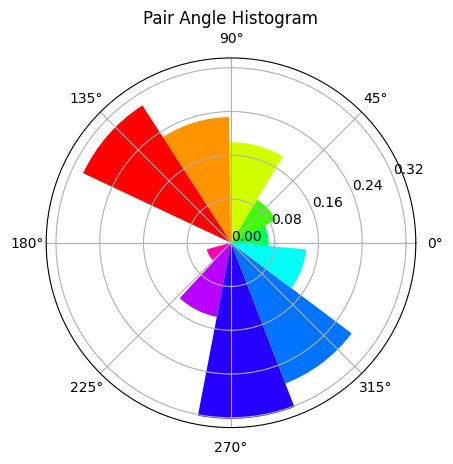

In [7]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=False, late_cutoff_high=latency_ms)

all final pairs positive?: True


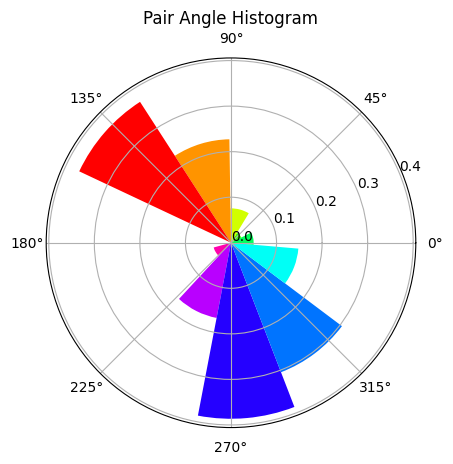

In [8]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True, late_cutoff_high=latency_ms)

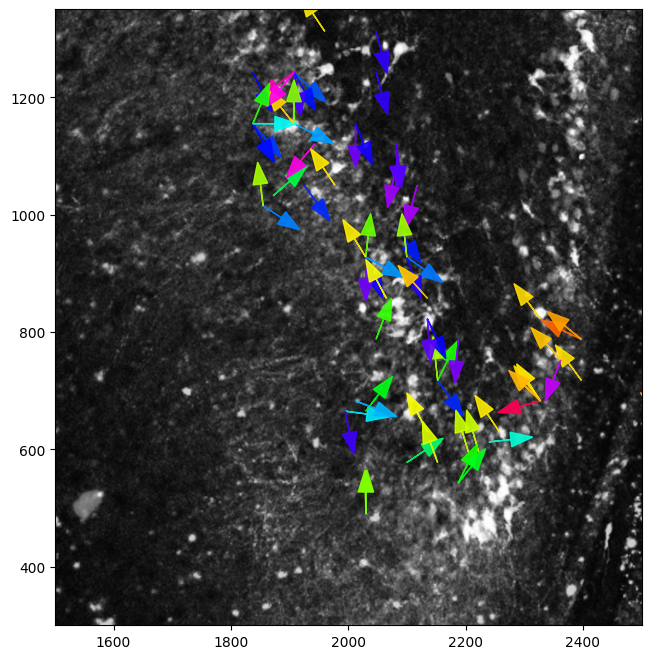

In [10]:
plot_vector_layout1( sd, good_pairs2, image_path="/workspaces/human_hippocampus/data/histology/hc110723_bw.jpeg", xlim=(1500,2500), ylim=(300,1350) )

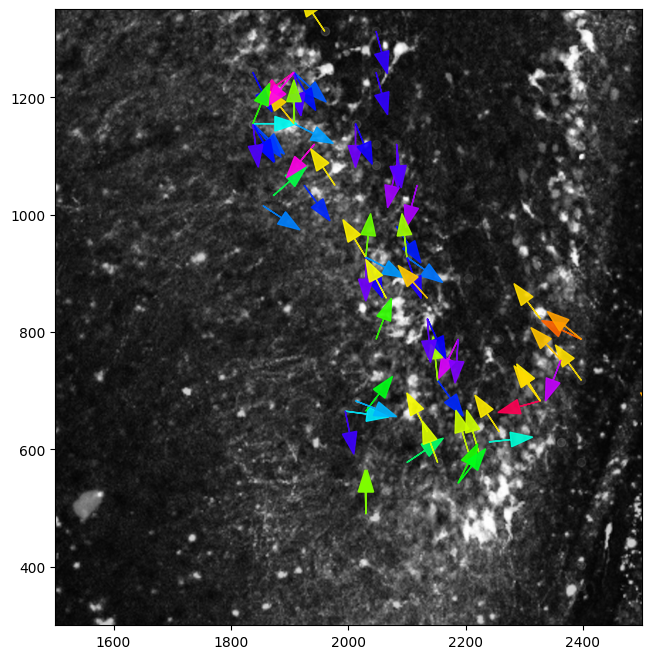

In [11]:
plot_vector_layout( sd, good_pairs2, image_path="/workspaces/human_hippocampus/data/histology/hc110723_bw.jpeg",
                   xlim=(1500,2500), ylim=(300,1350) )

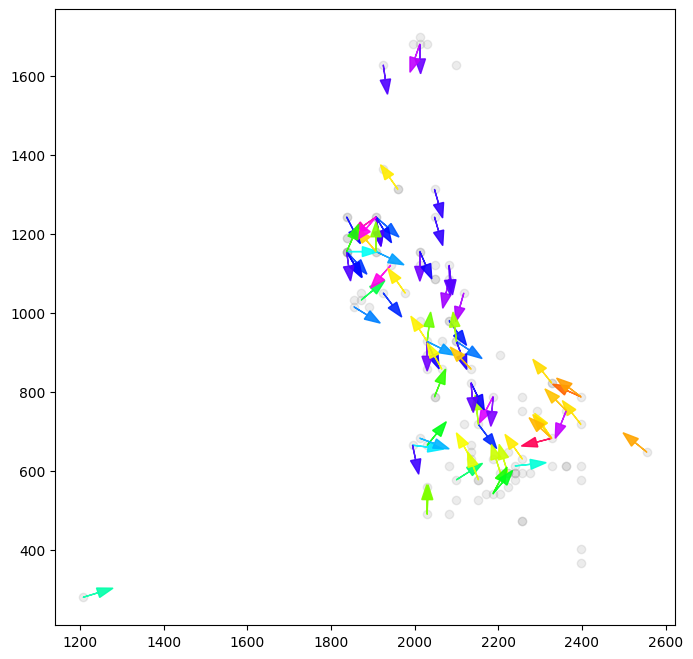

In [12]:
plot_vector_layout( sd, good_pairs2)

In [13]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs, sd, ms_cutoff_high=latency_ms ):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs, sd, ms_cutoff_high=latency_ms)

interactive(children=(IntSlider(value=38, description='pair_i', max=77), Output()), _dom_classes=('widget-inte…

# Curate Arrows

Pairs removed by SD cutoff: 4


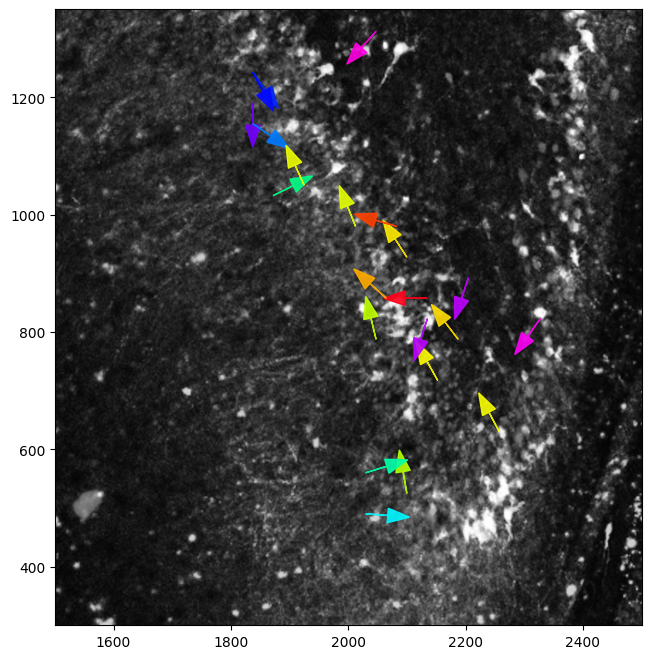

In [6]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc110723_bw.jpeg",
                   figsize=(8, 8), xlim=(1500,2500), ylim=(300,1350) ,
                   sd_cuttoff=.5 , latency_ms=30 )

Pairs removed by SD cutoff: 3


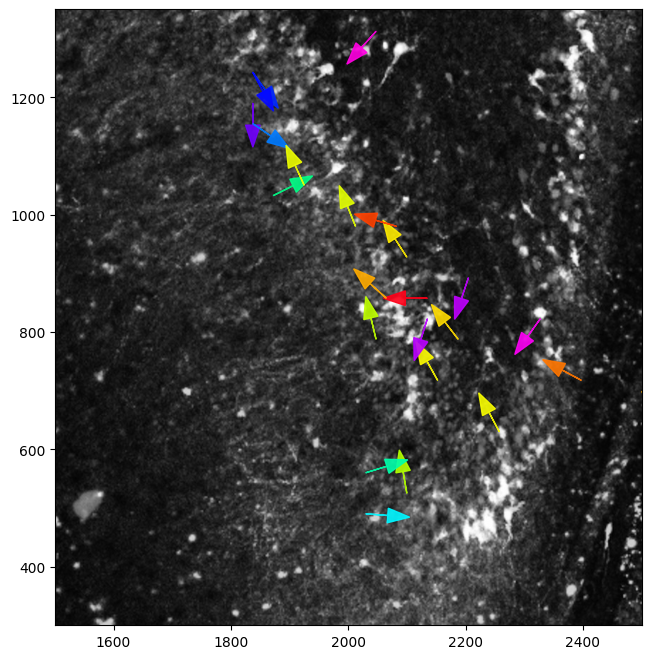

In [7]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc110723_bw.jpeg",
                   figsize=(8, 8), xlim=(1500,2500), ylim=(300,1350) ,
                   sd_cuttoff=1 , latency_ms=30 )

# <font color="brown"> Arrow Check

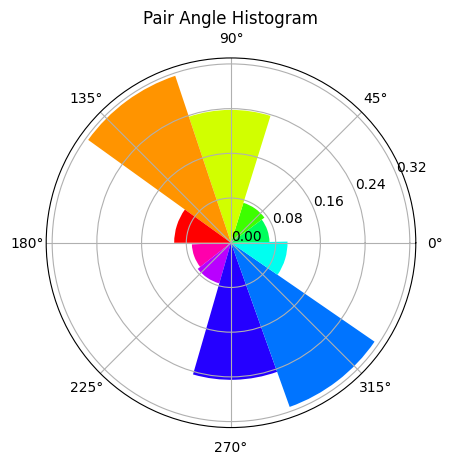

In [3]:
arrow_check2(sd)

# <font color="violet"> Haussler Check

## <font color="violet"> Fit polynomial to data

/tmp/ipykernel_14841/46999818.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


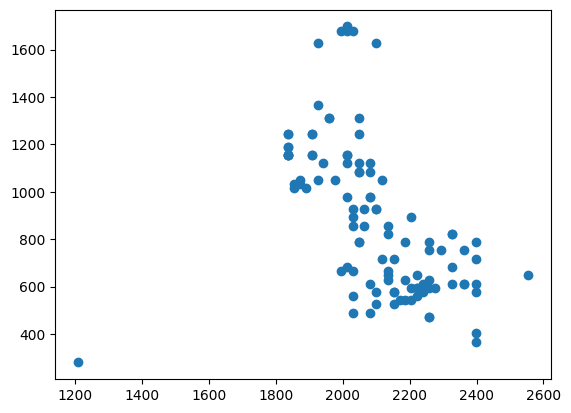

In [5]:

neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)
x = neuron_xy[:,0]
y = neuron_xy[:,1]

plt.scatter( x, y  ) 



In [6]:
x

array([2222.5, 2047.5, 2152.5, 2327.5, 2205. , 2222.5, 1995. , 2257.5,
       2240. , 2240. , 2205. , 2170. , 2555. , 1872.5, 2205. , 2397.5,
       2135. , 2222.5, 2222.5, 2082.5, 2397.5, 2187.5, 2397.5, 2240. ,
       2100. , 2030. , 2100. , 2275. , 1837.5, 2327.5, 2327.5, 2065. ,
       2135. , 2397.5, 2030. , 2257.5, 2327.5, 2152.5, 2012.5, 2012.5,
       2082.5, 2117.5, 2257.5, 2152.5, 1855. , 1207.5, 1942.5, 1977.5,
       2082.5, 2030. , 2257.5, 2397.5, 2397.5, 2292.5, 2135. , 2100. ,
       1925. , 2362.5, 2362.5, 2030. , 2065. , 2012.5, 1960. , 1907.5,
       1872.5, 2030. , 2135. , 2012.5, 2187.5, 2135. , 1837.5, 2100. ,
       2082.5, 2047.5, 2012.5, 2047.5, 2187.5, 1925. , 2012.5, 2257.5,
       2257.5, 2030. , 2082.5, 2047.5, 2030. , 1995. , 2047.5, 2012.5,
       1837.5, 1837.5, 1907.5, 2100. , 2047.5, 2117.5, 2240. , 1855. ,
       1837.5, 1890. , 1907.5, 1925. , 2082.5, 2047.5, 1837.5, 1837.5,
       1907.5, 2152.5, 1837.5, 1960. , 2362.5])

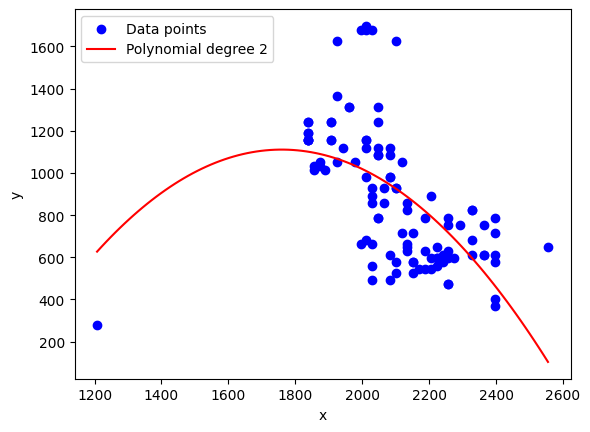

In [7]:
# Fit polynomial of degree n
degree = 2  # Change this to fit higher-degree polynomial
coefficients = np.polyfit(x, y, degree)

# Create polynomial function from coefficients
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial line
x_plot = np.linspace(min(x), max(x), 100)
y_plot = polynomial(x_plot)

# Plot the data points
plt.scatter(x, y, color='blue', label='Data points')

# Plot the polynomial line
plt.plot(x_plot, y_plot, color='red', label=f'Polynomial degree {degree}')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()

## <font color="violet"> Get index from fit for each neuron

In [8]:
def find_closest_indices(x, y, x_plot, y_plot):
    closest_indices = []
    for xi, yi in zip(x, y):
        distances = np.sqrt((x_plot - xi)**2 + (y_plot - yi)**2)
        closest_index = np.argmin(distances)
        closest_indices.append(closest_index)
    return closest_indices


In [9]:

closest_indices = find_closest_indices(x, y, x_plot, y_plot)


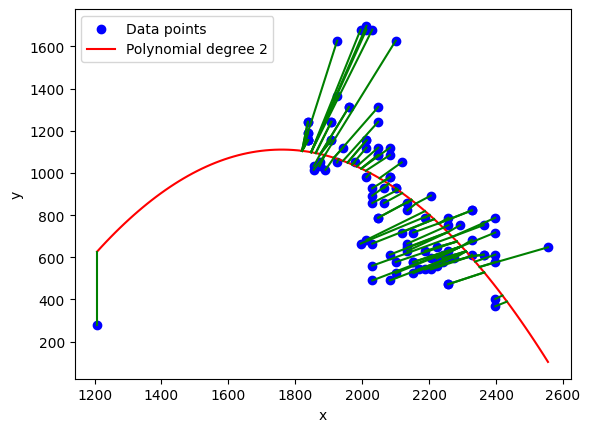

In [10]:

# Plot the data points
plt.scatter(x, y, color='blue', label='Data points')

# Plot the polynomial line
plt.plot(x_plot, y_plot, color='red', label=f'Polynomial degree {degree}')

for i, idx in enumerate(closest_indices):
    plt.plot([x[i], x_plot[idx]], [y[i], y_plot[idx]], color='green')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## <font color="violet"> Get index and angle for each arrow

<font color="red"> <b> Not weighted by firing rate

In [11]:
from sklearn import preprocessing

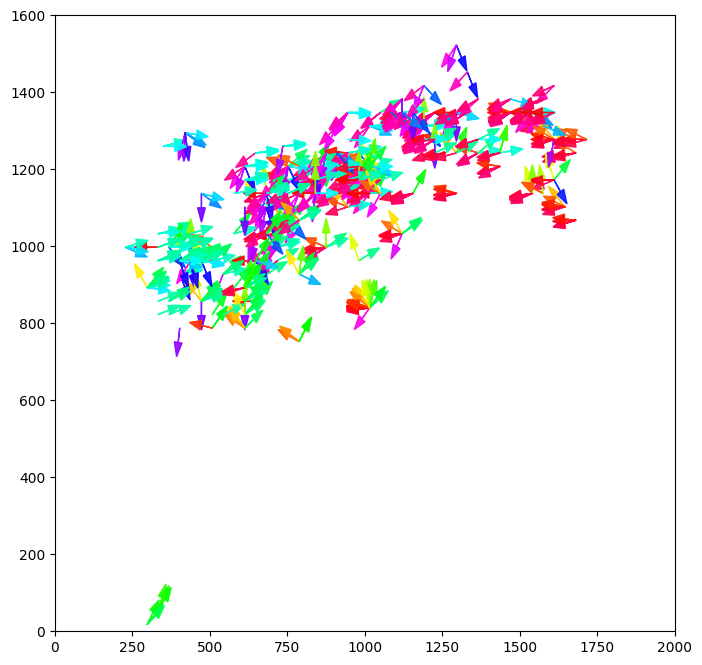

In [ ]:
plot_vector_layout1( sd, good_pairs,  xlim=(0,2000), ylim=(0,1600))

In [12]:
pairs = good_pairs

/tmp/ipykernel_14841/310852070.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


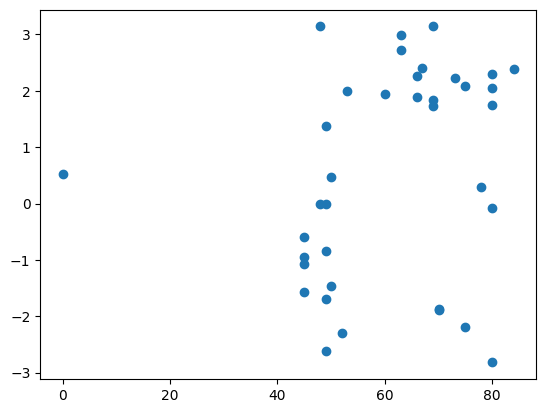

In [13]:

# Get the x/y locations of the start and end neurons of each pair
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)

# Get angle for each arrow
starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
ends = neuron_xy[ [pair[1] for pair in pairs] ]
centered = ends-starts   # Get the directions of arrows, then make of of them the same length
normalized = preprocessing.normalize(centered) #* 75
angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 
#angles2 = (angles*-1+ np.pi)/np.pi/2

# closest indices
fit_indices = [closest_indices[pair[0]] for pair in pairs] 



plt.scatter( fit_indices, angles )

# Plot original scatter
# plt.figure(figsize=(8, 8))
# ax = plt.axes()
# plt.xlim( xlim )
# plt.ylim( ylim )    

# Draw Arrows
# cmap = cm.get_cmap('hsv')
# for i in range(len(starts)):
#     arrow = FancyArrow( 
#             starts[i][0], starts[i][1], normalized[i][0]*75, normalized[i][1]*75, length_includes_head=True, head_width=25,
#             linewidth=1, color=cmap(angles2[i]), alpha=0.9 ) #color="red"
#     plt.gca().add_patch(arrow)



## <font color="violet"> Random

In [14]:
# Get the x/y locations of the start and end neurons of each pair
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)

pair_angles = []                     # get list (without duplicates) of all pairs angles
start_idx = []
for i in range(sd.N):
    for j in range(sd.N):
        if i==j:
            continue
        start=neuron_xy[i]
        end=neuron_xy[j]
        pair_angles.append( np.arctan2(-(end[1]-start[1]), end[0]-start[0]) * -1 )
        start_idx.append( closest_indices[i] )

/tmp/ipykernel_14841/2580257528.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


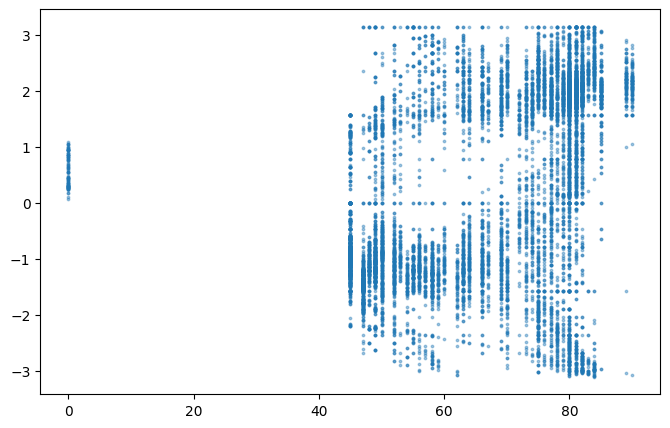

In [15]:

plt.figure(figsize=(8, 5))
plt.scatter( start_idx, pair_angles , alpha=.4, s=3)

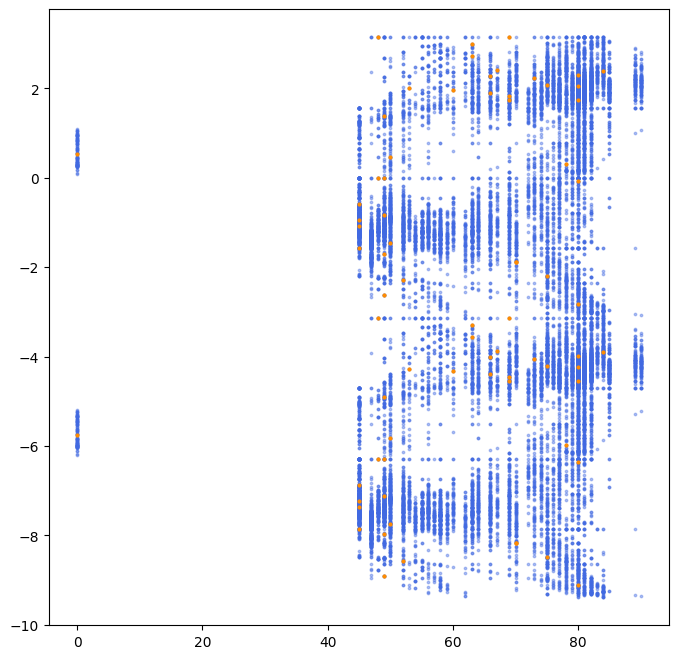

In [16]:

plt.figure(figsize=(8, 8))
plt.scatter( start_idx, pair_angles , alpha=.4, s=3, c="royalblue")
plt.scatter( start_idx, np.array(pair_angles)-2*np.pi , alpha=.4, s=3, c="royalblue")


plt.scatter( fit_indices, angles  , alpha=1, s=4, c="darkorange")
plt.scatter( fit_indices, np.array(angles)-2*np.pi , alpha=1, s=4, c="darkorange")